In [3]:
pip install tensorflow datasets opencv-python matplotlib pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.4 MB/s eta 0:00:00


In [4]:
!pip install datasets huggingface_hub

In [1]:
from huggingface_hub import login

login()

In [5]:
from datasets import load_dataset
ds = load_dataset("Daniellau119/trad_chineseHKOCR")

# taking only first 5k images for training
ds_train = ds['train'].select(range(5000))

print("Dataset loaded successfully. Total samples:", len(ds_train))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/467 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/453M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset loaded successfully. Total samples: 5000


In [6]:
import tensorflow as tf
import numpy as np
import cv2

def preprocess_data(sample):
    image = sample['image']

    # Convert image to numpy array
    img_array = np.array(image) / 255.0  # Normalize

    # Extracting bounding boxes and text labels
    boxes = []
    labels = []
    words = []

    for item in sample['ocr']:
        boxes.append(item['box'])
        labels.append(item['cls'])
        words.append(item['word'])

    return img_array, np.array(boxes), np.array(labels), words

train_data = [preprocess_data(sample) for sample in ds_train]

print("Preprocessing complete. Sample shape:", train_data[0][0].shape)

Preprocessing complete. Sample shape: (250, 250, 3)


In [7]:
!apt-get update
!apt-get install -y fonts-noto-cjk

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,315 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,655 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,674 kB]
Get:13 http://archive.ubuntu.com/ubuntu jamm

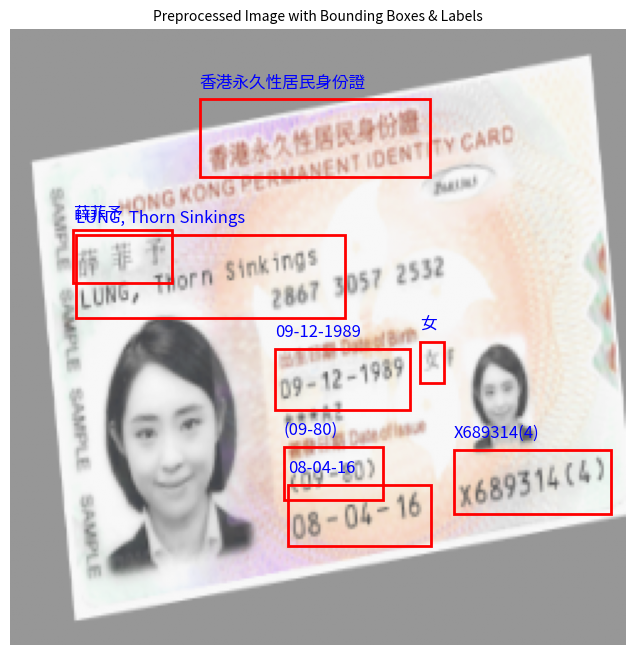

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'Noto Sans CJK JP'  # Font for recognizing Chinese, English, and numbers

# font file path
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"

def visualize_sample(sample_index):
    img, boxes, labels, words = train_data[sample_index]

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)

    # Drawing bounding boxes
    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box
        width, height = x_max - x_min, y_max - y_min

        rect = patches.Rectangle(
            (x_min, y_min), width, height,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

        font_prop = fm.FontProperties(fname=font_path, size=12, weight='bold')
        ax.text(x_min, y_min - 5, words[i], color='blue', fontproperties=font_prop)

    plt.title("Preprocessed Image with Bounding Boxes & Labels", fontproperties=fm.FontProperties(fname=font_path))
    plt.axis("off")
    plt.show()

visualize_sample(9)


In [9]:
BATCH_SIZE = 16

def data_generator():
    for img, boxes, labels, _ in train_data:
        yield img, {"bbox_output": boxes[0], "class_output": labels[0]}

train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(250, 250, 3), dtype=tf.float32),
        {
            "bbox_output": tf.TensorSpec(shape=(4,), dtype=tf.float32),
            "class_output": tf.TensorSpec(shape=(), dtype=tf.int32),
        }
    )
).batch(BATCH_SIZE).repeat()


In [10]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, LSTM, Bidirectional,Reshape

In [11]:
from tensorflow.keras import layers, Model

def build_model():
    inputs = layers.Input(shape=(250, 250, 3))

    # CNN Feature extraction
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    # Bounding Box output (4 coordinates)
    bbox_output = layers.Dense(4, activation='sigmoid', name="bbox_output")(x)

    # Classification output (8 classes for text recognition)
    class_output = layers.Dense(8, activation='softmax', name="class_output")(x)

    model = Model(inputs=inputs, outputs=[bbox_output, class_output])
    return model

model = build_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 250, 250, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 250, 250, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 125, 125, 32)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 125, 125, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 62, 62, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 62, 62, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 31, 31, 128)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 123008)         │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │     31,490,304 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bbox_output (Dense)       │ (None, 4)              │          1,028 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class_output (Dense)      │ (None, 8)              │          2,056 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 31,586,636 (120.49 MB)

 Trainable params: 31,586,636 (120.49 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(
    optimizer='adam',
    loss={
        "bbox_output": "mse",   # Mean Squared Error for bounding box prediction
        "class_output": "sparse_categorical_crossentropy"
    },
    metrics={"bbox_output": "mae", "class_output": "accuracy"}
)

# Training the model
EPOCHS = 11
STEPS_PER_EPOCH=30
history = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH)


Epoch 1/11
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - bbox_output_loss: 10095.4736 - bbox_output_mae: 84.7760 - class_output_accuracy: 0.8701 - class_output_loss: 0.3071 - loss: 10095.7803
Epoch 2/11
30/30 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - bbox_output_loss: 10149.4717 - bbox_output_mae: 84.9031 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 10149.4717
Epoch 3/11
30/30 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - bbox_output_loss: 9988.0088 - bbox_output_mae: 84.6103 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 9988.0088
Epoch 4/11
30/30 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - bbox_output_loss: 10029.8848 - bbox_output_mae: 84.7712 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 10029.8848
Epoch 5/11
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - bbox_output_loss: 9846.3770 - bbox_output_mae: 83.2845 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 9846.3770
Epoch 6/11
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - b

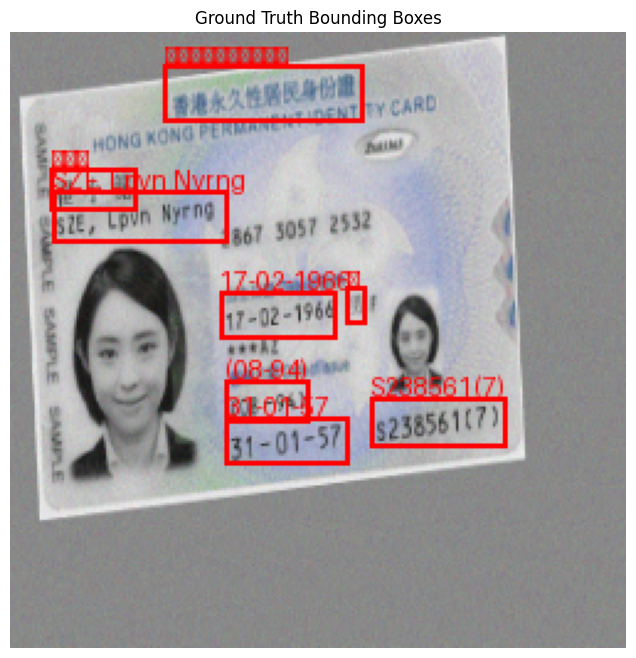

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


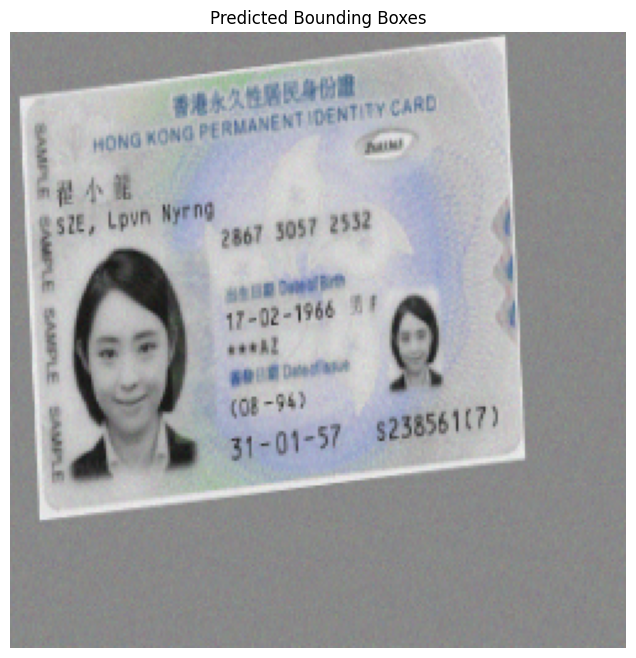

Predicted Class: 0
True Words in Image: ['香港永久性居民身份證', '翟小龍', 'SZE, Lpvn Nyrng', '17-02-1966', '男', '(08-94)', '31-01-57', 'S238561(7)']


In [15]:
import random
from PIL import ImageDraw

def draw_bounding_boxes(image, boxes, texts, color="red"):
    img_copy = image.copy()
    draw = ImageDraw.Draw(img_copy)

    for box, text in zip(boxes, texts):
        x_min, y_min, x_max, y_max = box
        draw.rectangle([x_min, y_min, x_max, y_max], outline=color, width=2)
        draw.text((x_min, y_min - 10), text, fill=color)

    return img_copy

sample_index = random.randint(0, 4999)
sample = ds['train'][sample_index]

# Extract image and ground truth labels
image = sample['image']
true_boxes = np.array([entry['box'] for entry in sample['ocr']])
true_texts = [entry['word'] for entry in sample['ocr']]

# Draw ground truth bounding boxes
image_with_gt = draw_bounding_boxes(image, true_boxes, true_texts, color="red")

# Display the image with ground truth annotations
plt.figure(figsize=(8, 8))
plt.imshow(image_with_gt)
plt.title("Ground Truth Bounding Boxes")
plt.axis("off")
plt.show()

# Preprocessing the random image for model input
img_array = np.array(image) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred_bbox, pred_class = model.predict(img_array)

pred_bbox = np.clip(pred_bbox[0] * 250, 0, 250)

predicted_image = draw_bounding_boxes(image, [pred_bbox], [f"Class {pred_class.argmax()}"], color="green")

plt.figure(figsize=(8, 8))
plt.imshow(predicted_image)
plt.title("Predicted Bounding Boxes")
plt.axis("off")
plt.show()

print(f"Predicted Class: {pred_class.argmax()}")
print(f"True Words in Image: {true_texts}")